In [373]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [374]:
import math
import numpy as np
from itertools import islice, count
import scipy.linalg as la
from tqdm import tqdm
from scipy.cluster import hierarchy

def twoDimEncoder(sequence, bar=False):
    sequence = sequence.upper()

    if bar:
        sequence = tqdm(sequence, unit=" bases", leave=False)
    m=1/2
    n=3/4

    x, y = [0], [0]
    for character in sequence:
      if character == "A":
        x.append(x[-1] + m)
        y.append(y[-1] -math.sqrt(n))
      elif character == "T":
        x.append(x[-1] + m)
        y.append(y[-1] + math.sqrt(n))
      elif character == "G":
        x.append(x[-1] + math.sqrt(n))
        y.append(y[-1] - m)
      elif character == "C":
        x.append(x[-1] +math.sqrt(n))
        y.append(y[-1] + m)
      else:
        x.append(x[-1])
        y.append(y[-1])  # no change in coord
    if bar:
        sequence.close()
    return x, y

def geometricalCenterCalculation(myArray):
  GC = 0
  GC=1/len(myArray)*sum(myArray)
  return GC
def eigVector(x,y):
  cov_mat = np.stack((x, y), axis = 0)
  cov_mat_=np.cov(cov_mat)
  eigvals, eigvecs = la.eig(cov_mat_)
  v1 = eigvecs[:,0]
  v2 = eigvecs[:,1]
  return v1, v2 
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

3.6955656264431327
1.1688566201357355
eigenvectors
[9.99999986e-01 1.67955080e-04]


0.0

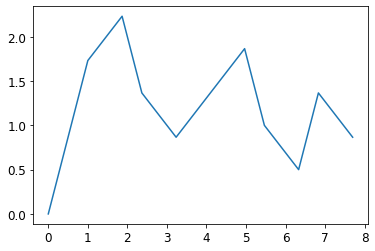

In [375]:
seq_test = 'TTCAGCCAGTG'
import matplotlib.pyplot as plt
plt.plot(twoDimEncoder(seq_test)[0], twoDimEncoder(seq_test)[1] )
seq_test = 'TTCAGCCAGTG'
import matplotlib.pyplot as plt
xA, yA = twoDimEncoder(seq_test)[0], twoDimEncoder(seq_test)[1]
print(geometricalCenterCalculation(xA))
print(geometricalCenterCalculation(yA))
print("eigenvectors")
print(eigVector(xA, yA)[0])
angle(eigVector(xA, yA)[0], eigVector(xA, yA)[0])

In [376]:
%pip install python-box
%pip install pyfaidx
%pip install scikit-bio
%pip install biopython

In [377]:
import math
from box import Box
from pyfaidx import Fasta
from tqdm import tqdm
from google.colab import files
def twoDVisualize(fasta):
    # check filetype
    if fasta is None:
        raise ValueError("FASTA file should be provided.")
    # get all the sequences
    seqs = []
    for i, _f in enumerate(fasta):
        for j, seq in enumerate(
            Fasta(_f, sequence_always_upper=True, read_long_names=False)
        ):
            seqs.append(
                Box(
                    name=seq.name,
                    raw_seq=str(seq),
                )
            )
    seq_names = []
    for index, record in enumerate(SeqIO.parse(fasta[0],"fasta")):
        if get_label_human(record.id)==None and get_label_different_hosts(record.id)==None:
          seq_names.append(record.id)
        elif get_label_human(record.id)==None and get_label_different_hosts(record.id)!=None:
          seq_names.append(get_label_different_hosts(record.id))         
        elif get_label_human(record.id)!=None and get_label_different_hosts(record.id)==None:
          seq_names.append(get_label_human(record.id)) 
    bar=True
    downsample=1
    # show a progress bar by processing multiple files
    if len(seqs) > 1 and bar:
        _seqs = tqdm(seqs, unit=" seqs", leave=False)
    else:
        _seqs = seqs
    fig= plt.figure(figsize=(20,16), dpi=100)
    data_points_seqs = []
    df_seqs_coordinates = pd.DataFrame()    
    for i, seq in enumerate(_seqs):
        # perform the actual transformation
        transformed = twoDimEncoder(seq.raw_seq)
        if downsample > 1:
            transformed = (transformed[0][::downsample], transformed[1][::downsample])
        y = transformed[1]
        data_points_seqs.append([transformed[0], y])
        x_column_name = 'x_' + seq_names[i] 
        y_column_name = 'y_' + seq_names[i] 
        new_df = pd.DataFrame({x_column_name: transformed[0], y_column_name: y})
        df_seqs_coordinates = pd.concat([df_seqs_coordinates, new_df], axis=1)        
        plt.plot(transformed[0], y, label=seq_names[i])
    print(new_df)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()
    fig.savefig("dimtwoplot.pdf")
    files.download("dimtwoplot.pdf")

In [378]:
from scipy.cluster.hierarchy import dendrogram, average
def adjust_dendrogram(*args, **kwargs):
  max_d = kwargs.pop('max_d', None)
  above_threshold_color=kwargs.pop('color_threshold_color', 'blue')
  annotate_above = kwargs.pop('annotate_above', 0)
  ddata = dendrogram(*args, **kwargs)
  if not kwargs.get('no_plot', False):
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('acc_no')
    plt.xlabel('distance')
    for i, d, c in zip(ddata['dcoord'], ddata['icoord'], ddata['color_list']):
      y = 0.5 * sum(d[1:3])
      x = i[1]
      if x > annotate_above:
        plt.plot(x, y, 'ko')
        plt.annotate("%.3g" % (1-x), (x, y), xytext=(-10, 10),
                       textcoords='offset points',
                       va='top', ha='center')
    if max_d:
      plt.axvline(x=max_d, c='k')
  return ddata

In [379]:
from scipy.cluster import hierarchy
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick


In [380]:
import math
import numpy as np
import pandas as pd
from itertools import islice, count
from tqdm import tqdm
from matplotlib.patches import Patch
from Bio import SeqIO, Phylo
import matplotlib
def distMatCalculate(fasta, newickCompare):
    # check filetype
    if fasta is None:
        raise ValueError("FASTA file should be provided.")
    # get all the sequences
    seqs = []
    for i, _f in enumerate(fasta):
        for j, seq in enumerate(
            Fasta(_f, sequence_always_upper=True, read_long_names=False)
        ):
            seqs.append(
                Box(
                    name=seq.name,
                    raw_seq=str(seq),
                )
            )
    seq_names = []
    df1 = pd.DataFrame(index=[*range(0, len(metadata_human), 1)], columns=metadata_human.columns.to_list())
    for index, record in enumerate(SeqIO.parse(fasta[0],"fasta")):
        if get_label_human(record.id)==None and get_label_different_hosts(record.id)==None:
          seq_names.append(record.id)
        elif get_label_human(record.id)==None and get_label_different_hosts(record.id)!=None:
          seq_names.append(get_label_different_hosts(record.id))         
        elif get_label_human(record.id)!=None and get_label_different_hosts(record.id)==None:
          seq_names.append(get_label_human(record.id))
          temp=(get_label_human(record.id)).replace('"', '').replace('___', '').split('|')
          #print(get_label_human(record.id))
          #print((metadata_human.loc[metadata_human['Accession'] == temp[0]]).values.flatten().tolist())
          df1.iloc[index]=(metadata_human.loc[metadata_human['Accession'] == temp[0]]).values.flatten().tolist()
    newick_names=[]
    for index, record in enumerate(SeqIO.parse(fasta[0],"fasta")):
      newick_names.append(record.id)           
    bar=True
    downsample=1
    # show a progress bar by processing multiple files
    if len(seqs) > 1 and bar:
        _seqs = tqdm(seqs, unit=" seqs", leave=False)
    else:
        _seqs = seqs

    xGC, yGC, eigVectorsLambdaOne, eigVectorsLambdaTwo, names = [], [], [], [], []
    for i, seq in enumerate(_seqs):
        # perform the actual transformation
        transformed = twoDimEncoder(seq.raw_seq)
        if downsample > 1:
            transformed = (transformed[0][::downsample], transformed[1][::downsample])
        y = transformed[1]
        x = transformed[0]
        xGC.append(geometricalCenterCalculation(x))
        yGC.append(geometricalCenterCalculation(y))
        eigVectorsLambdaOne.append(eigVector(x,y)[0])
        eigVectorsLambdaTwo.append(eigVector(x,y)[1])
        names.append(seq.name)            
    dist = []
    for i in range (0, len(xGC)):
      for j in range (0, len(xGC)):
          dist.append(calculateDistance(xGC[i], yGC[i], xGC[j], yGC[j]))
    dist=np.asarray(dist).reshape(len(xGC),len(xGC))
    anglesLabmdaOne, anglesLabmdaTwo, angles=[], [], []
    for i in range (0, len(eigVectorsLambdaOne)):
      for j in range (0, len(eigVectorsLambdaOne)):
          if i!=j:
            anglesLabmdaOne.append(angle(eigVectorsLambdaOne[i], eigVectorsLambdaOne[j]))
            anglesLabmdaTwo.append(angle(eigVectorsLambdaTwo[i], eigVectorsLambdaTwo[j]))
          if i==j:
            anglesLabmdaOne.append(0)
    for i in range (0, len(anglesLabmdaOne)):
      angles.append(sum([anglesLabmdaOne[i], anglesLabmdaOne[i]]))
    angles=np.asarray(angles).reshape(len(xGC),len(xGC))
    distMat=angles*dist
    distMat=distMat/100
    from skbio.stats.distance import DistanceMatrix
    distM = DistanceMatrix(distMat, seq_names)
    lm = average(distM.condensed_form())
    if get_label_different_hosts(record.id)==None and get_label_human(record.id)!=None:
      fig= plt.figure(figsize=(30,30), dpi=100)
      axes = fig.add_subplot(1, 1, 1)
      legend_elements = (Patch(facecolor='#ffa756', label='North America'), Patch(facecolor='#069af3', label='Asia'), Patch(facecolor='#96f97b', label='Europe'), Patch(facecolor='#e50000', label='South America'), Patch(facecolor='#9a0eea', label='Africa'), Patch(facecolor='#13eac9', label='Australia'))
      axes.legend(handles=legend_elements, loc='upper left')
      d = adjust_dendrogram(lm, labels=seq_names, orientation='left', link_color_func=lambda x: 'black')
      my_palette = plt.cm.get_cmap( "rainbow", 6)
      print(my_palette)
      df1['Continent']=pd.Categorical(df1['Continent'])
      my_color=df1['Continent'].cat.codes
      #print(my_color)
      #print(df1['Continent'])
      # Apply the right color to each label
      ax = plt.gca()
      xlbls = ax.get_ymajorticklabels()
      num=-1
      for lbl in xlbls:
        strlbl=str(lbl)
        for i in range(0, len(df1['Accession']), 1):
          #print(df1['Accession'].values[i])
          #print(strlbl)
          if df1['Accession'].values[i] in strlbl:     
            val=my_color[i]
            lbl.set_color(my_palette(val))    
    elif get_label_different_hosts(record.id)!=None and get_label_human(record.id)==None:
      fig= plt.figure(figsize=(15,10), dpi=300)
      d = adjust_dendrogram(lm, labels=seq_names, orientation='left', color_threshold=0.15, above_threshold_color='black')
    tree = hierarchy.to_tree(lm, False)
    nwk=getNewick(tree, "", tree.dist, seq_names)
    plt.ioff()
    if newickCompare==1:
          nwk=getNewick(tree, "", tree.dist, newick_names)
          plt.close(fig)
    else:
          nwk=getNewick(tree, "", tree.dist, seq_names)
          fig.savefig('dendoPlot.pdf')
          files.download("dendoPlot.pdf")
          plt.show()
    return nwk

In [381]:
import pandas as pd
metadata_human = pd.read_csv("/content/drive/My Drive/DSinLS20/week11/code/input/large_dataset_metadata.csv")
metadata_human

,Accession,Length,Geo_Location,Host,Collection_Date,Continent
0,NC_045512,29903,China,Homo sapiens,2019-12,Asia
1,MT093631,29860,China,Homo sapiens,2020-01-08,Asia
2,MT079846,29903,China,Homo sapiens,2020-01-22,Asia
3,MT079847,29872,China,Homo sapiens,2020-01-22,Asia
4,MT079848,29880,China,Homo sapiens,2020-01-22,Asia
5,MT510728,29903,China,Homo sapiens,2020-02-13,Asia
6,MT582452,29782,Germany: Dusseldorf,Homo sapiens,2020-03-23,Europe
7,MT527184,29834,Italy: Lazio,Homo sapiens,2020-03-23,Europe
8,MT528235,29818,Italy: Lazio,Homo sapiens,2020-03-23,Europe
9,MT528238,29834,Italy: Lazio,Homo sapiens,2020-03-23,Europe


In [382]:
codes_human = []
names_human = []
continent_human = []
for index, row in metadata_human.iterrows():
    acc_no = row['Accession']

    if acc_no in ['NC_045512', 'MT093631']:
      new_code = acc_no + '.2'
    elif acc_no in ['LC556316', 'LC556317', 'LC556315']:
      new_code = acc_no + '.1'

    else:
      new_code = acc_no + '.1'
    new_name = '"'+'___'+acc_no + '|' + (row['Geo_Location']).replace(': ', '-').replace(' ', '_') + '|' + row['Collection_Date']+'"'
    codes_human.append(new_code)
    names_human.append(new_name)

In [383]:
def get_label_human(acc_no):    
  for i in range(0, len(codes_human)):
    if acc_no==codes_human[i]:
      name=names_human[i]
      return name

In [384]:
def get_label_different_hosts(acc_no):
    code=['JQ065048', 'MN996528', 'NC_034972', 'NC_019843', 'KX389094', 'MG772934', 'MT084071']
    host=['___Wigeon', '___H._Sapiens_COVID-19', '___Rodent', '___H._Sapiens_MERS', '___Red_junglefowl', '___Horseshoe_bat', '___Pangolin']    
    for i in range(0, len(code)):
      if acc_no==code[i]:
        name=host[i]
        return name

In [385]:
%cd "/content/drive/My Drive/DSinLS20/week11/code/input"

/content/drive/My Drive/DSinLS20/week11/code/input


No handles with labels found to put in legend.


       x____Pangolin  y____Pangolin
0           0.000000       0.000000
1           0.866025       0.500000
2           1.366025      -0.366025
3           2.232051       0.133975
4           3.098076      -0.366025
...              ...            ...
27209   16220.044493     213.857603
27210   16220.910518     214.357603
27211   16221.776544     214.857603
27212   16222.642569     214.357603
27213   16223.142569     213.491577

[27214 rows x 2 columns]


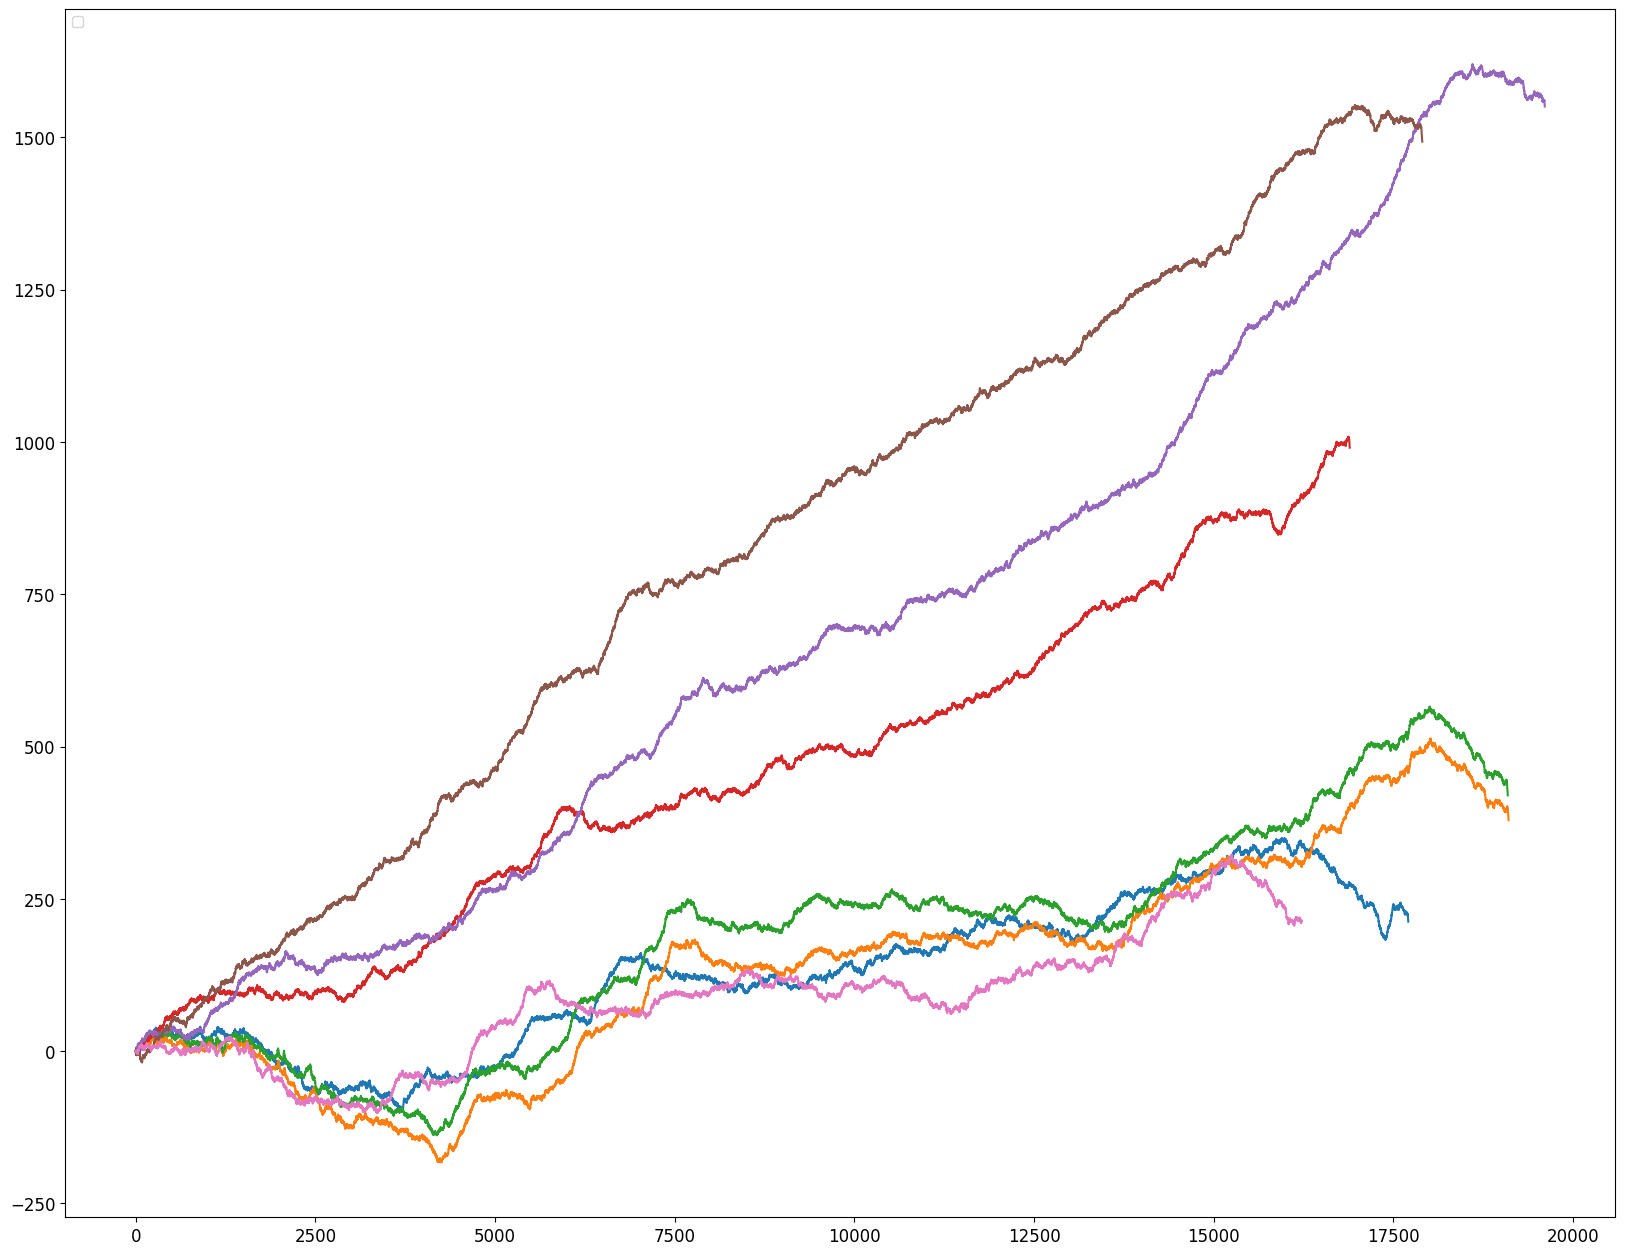

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [386]:
twoDVisualize(['different_hosts_sequences.fasta'])

       x_"___MT510692|Egypt|2020-05-02"  y_"___MT510692|Egypt|2020-05-02"
0                              0.000000                          0.000000
1                              0.866025                         -0.500000
2                              1.366025                          0.366025
3                              1.866025                          1.232051
4                              2.732051                          1.732051
...                                 ...                               ...
29756                      19017.381291                        392.335097
29757                      19017.881291                        393.201122
29758                      19018.381291                        392.335097
29759                      19018.881291                        391.469071
29760                      19019.381291                        392.335097

[29761 rows x 2 columns]


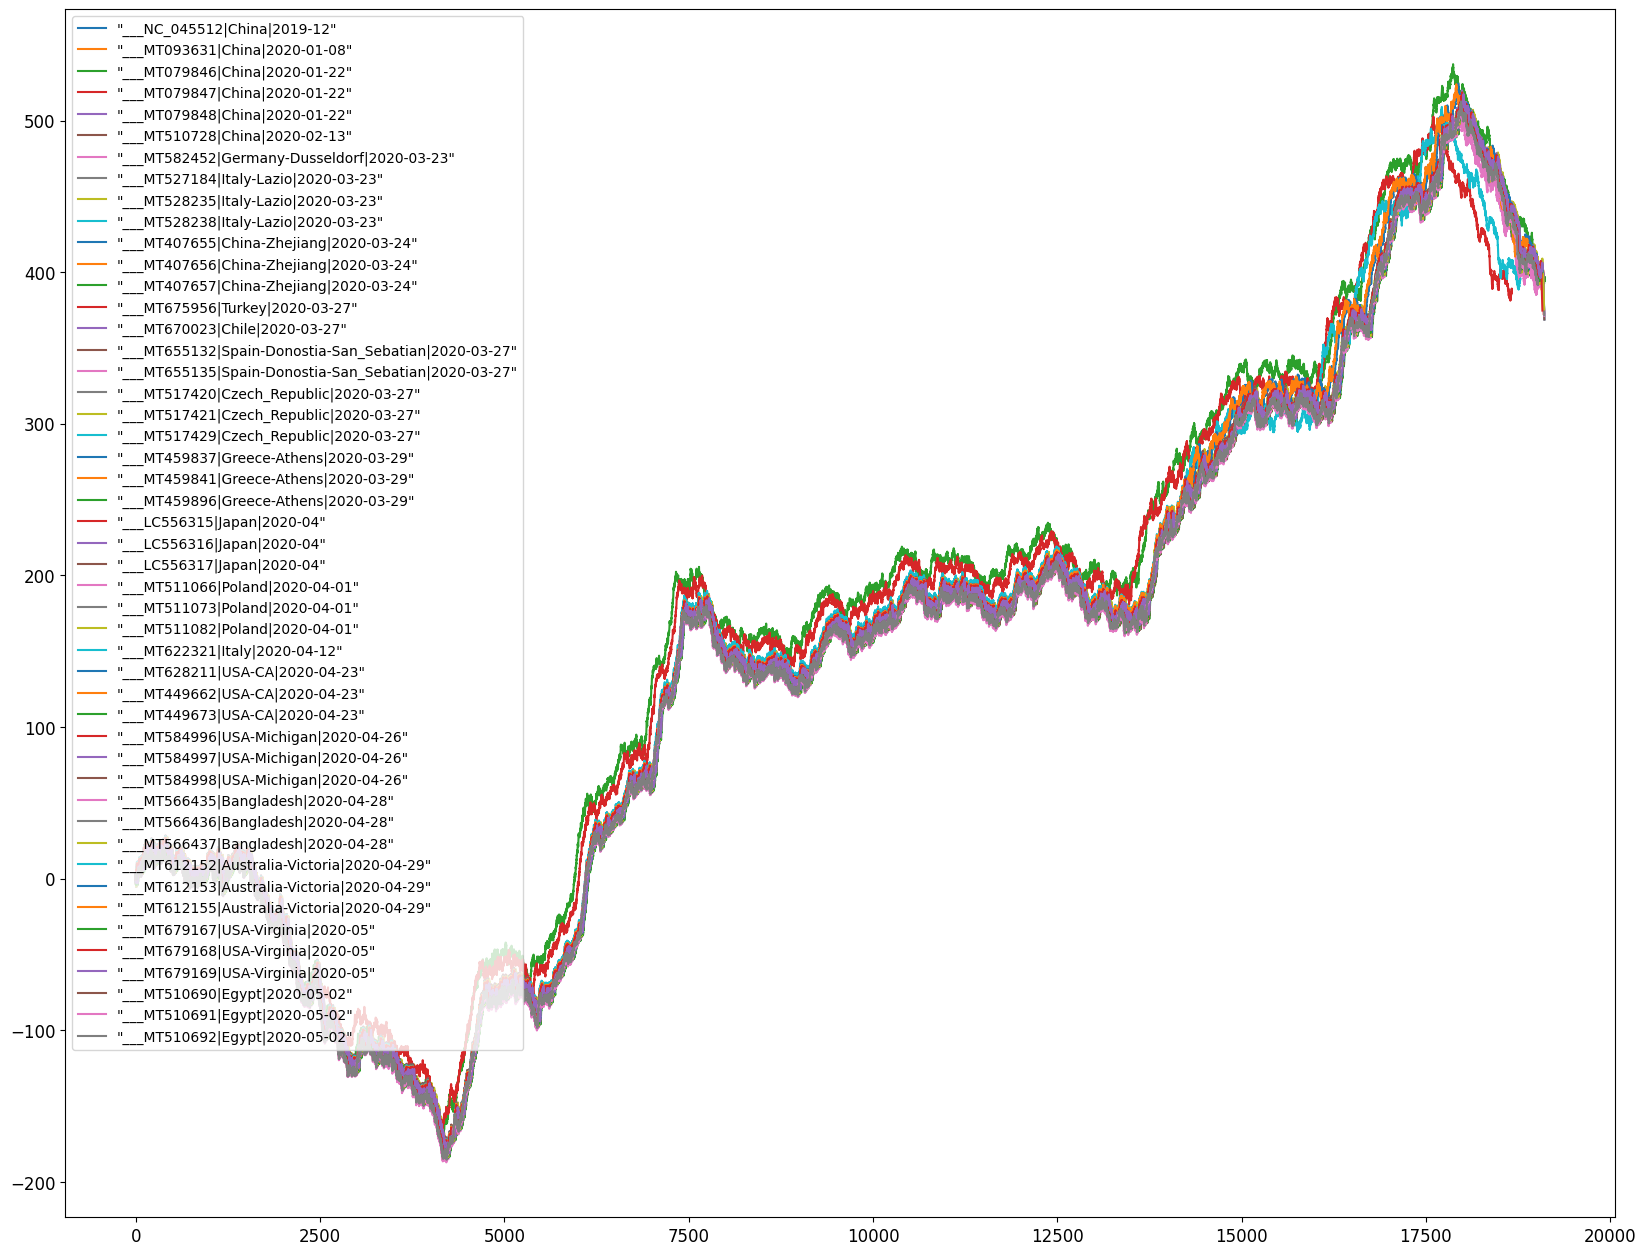

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [387]:
twoDVisualize(['large_dataset_sequences.fasta'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

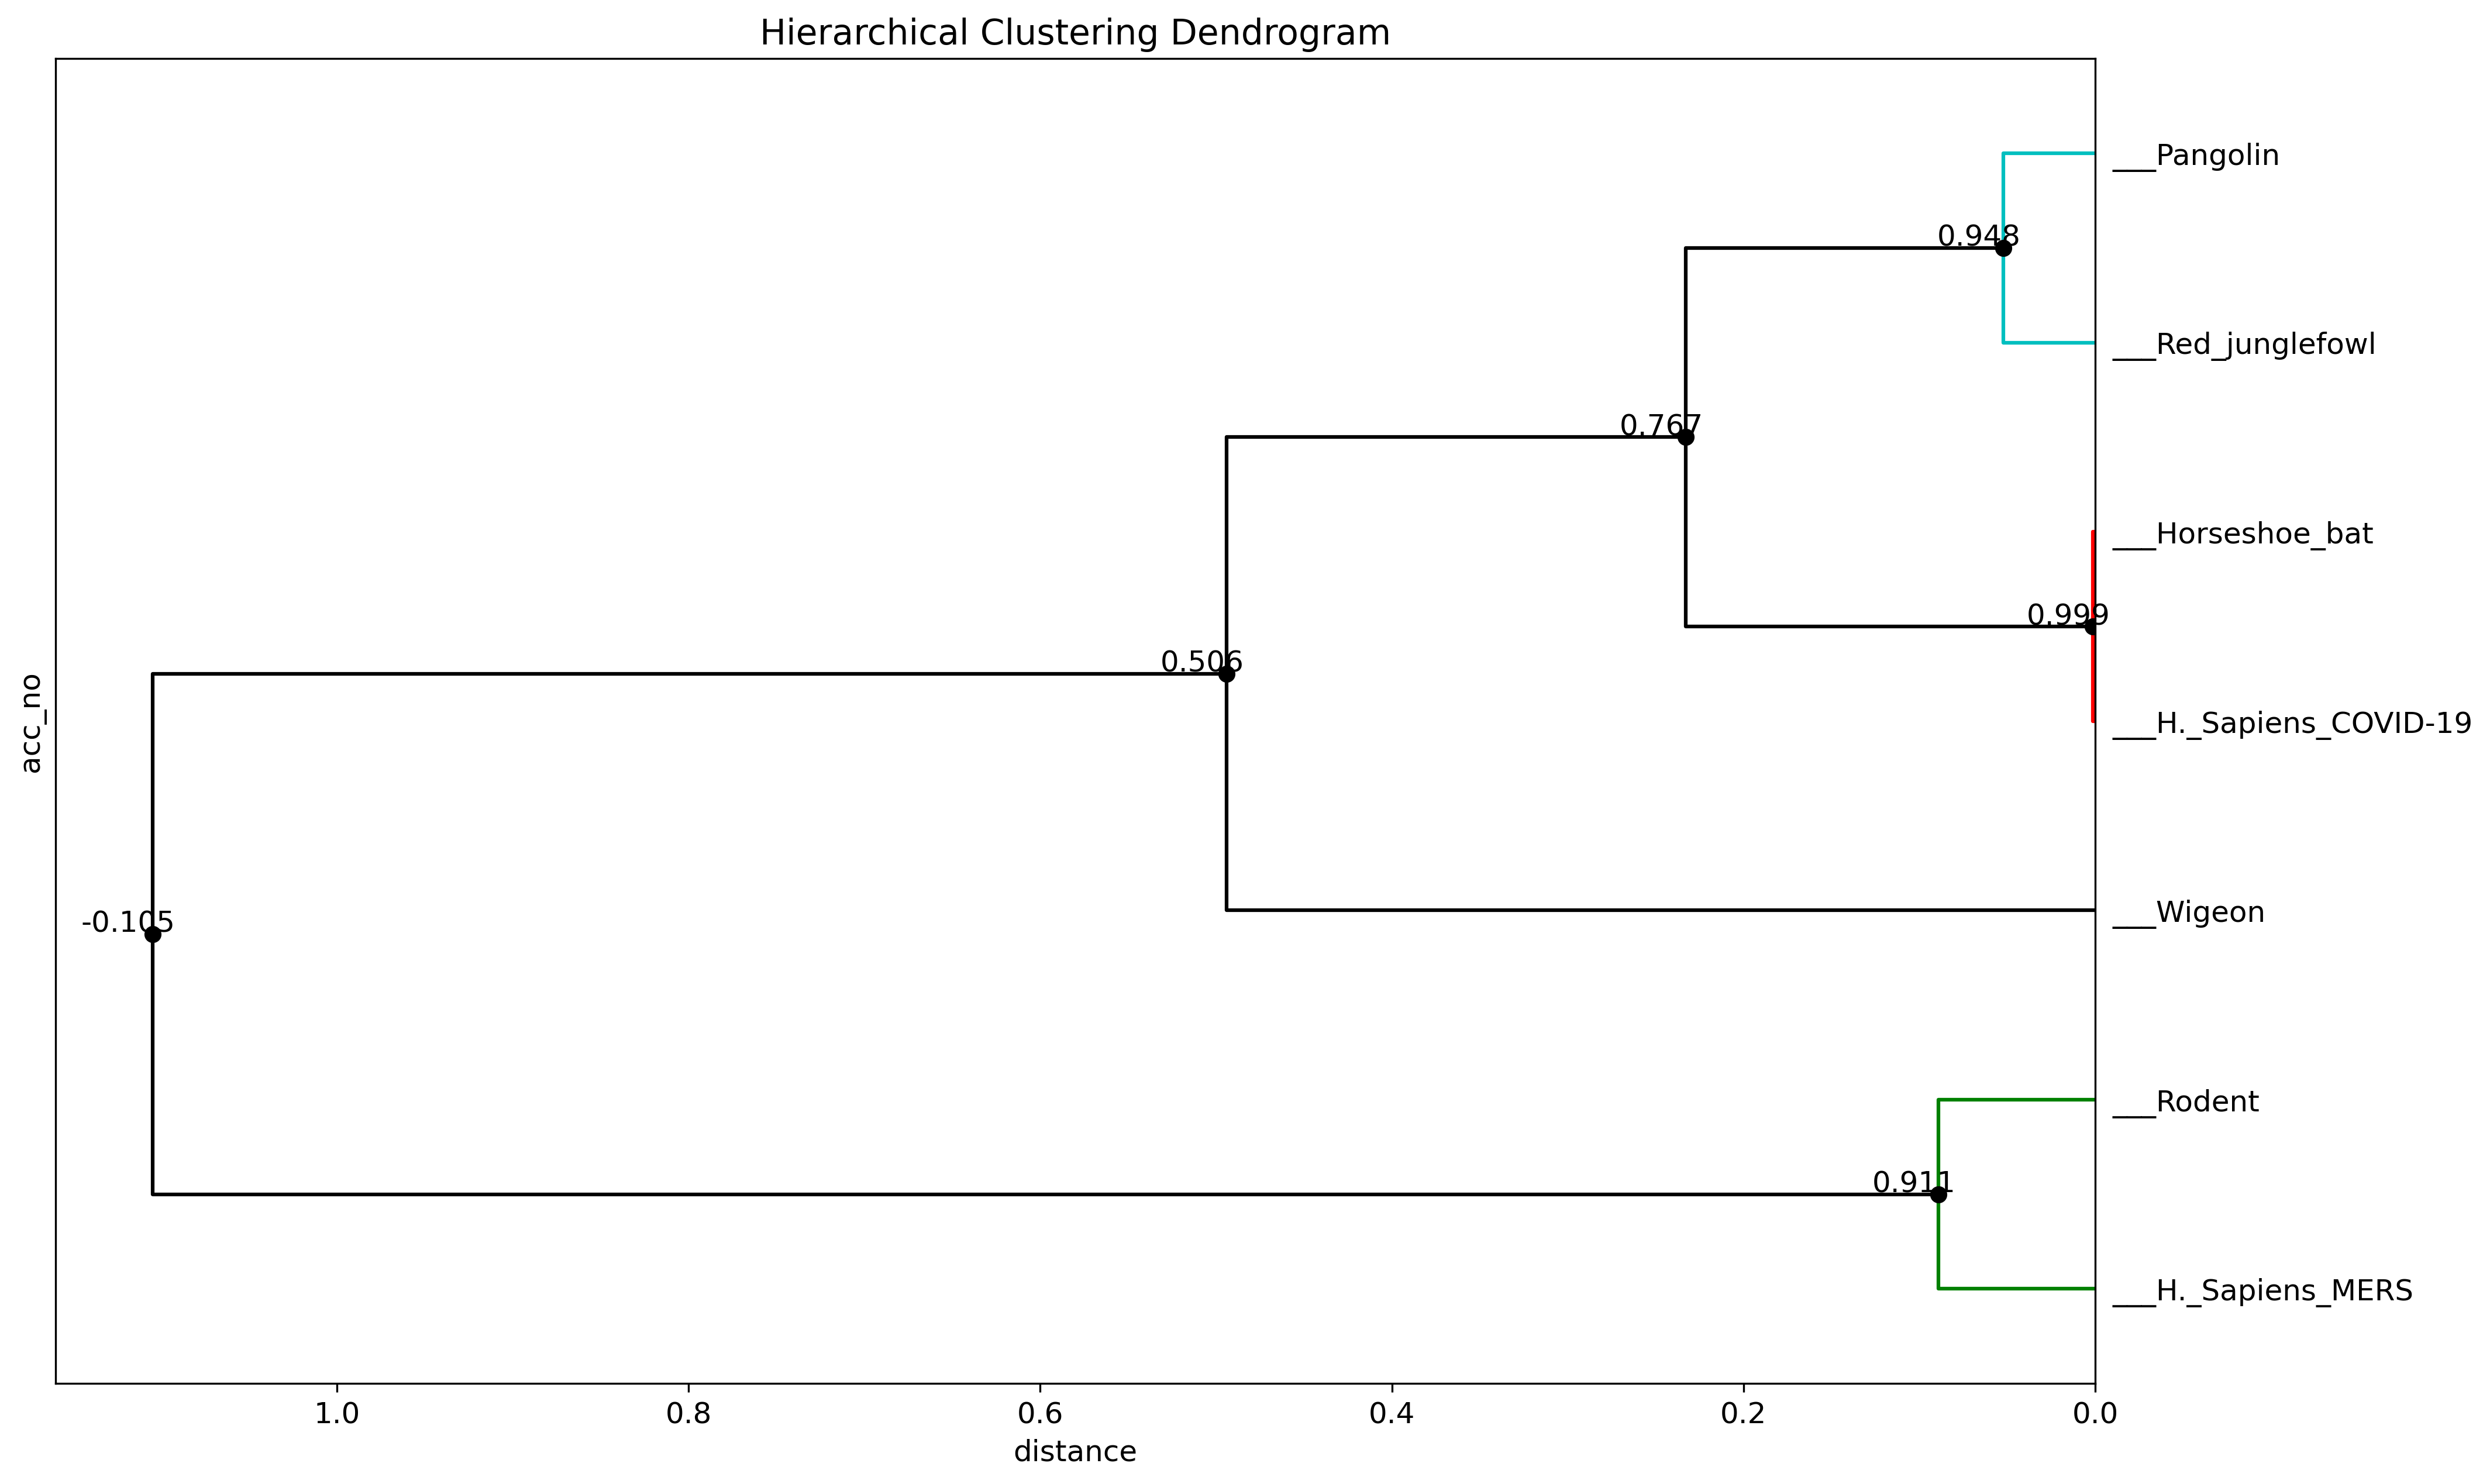

In [388]:
treeOne=distMatCalculate(['different_hosts_sequences.fasta'], 0)


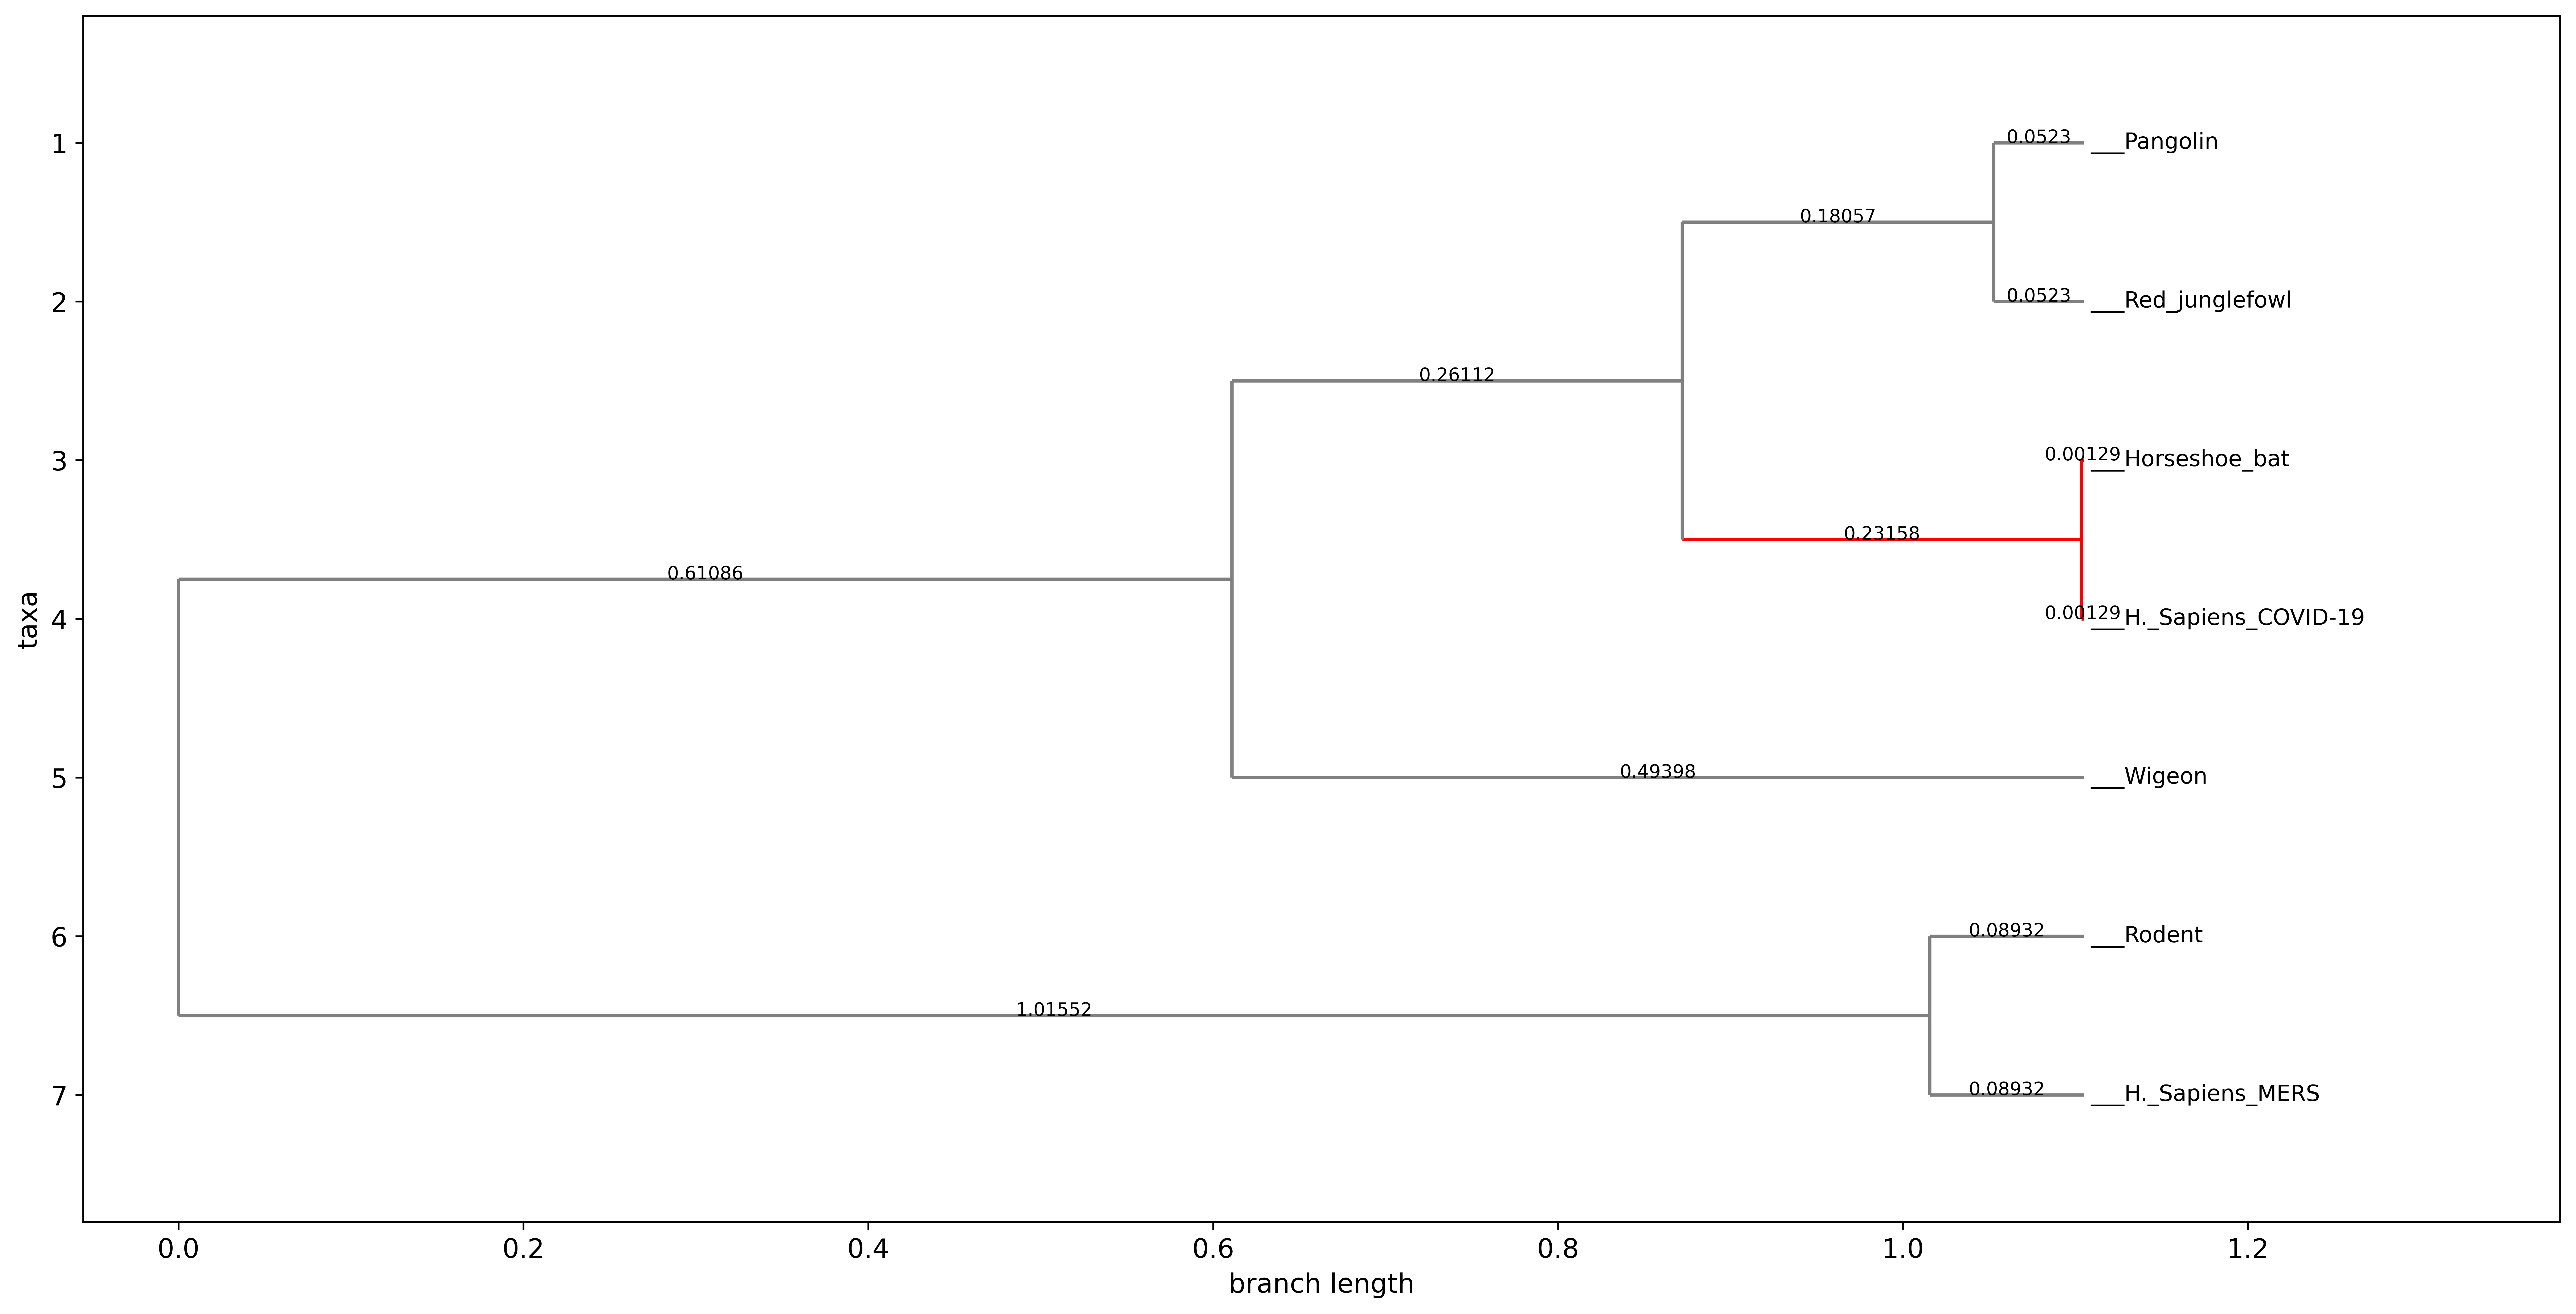

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [389]:
import io
from io import StringIO

fig = plt.figure(figsize=(20, 10), dpi=600)
axes = fig.add_subplot(1, 1, 1)
handle = StringIO(treeOne)
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=10)

tree.root.color = "grey"
tree.clade[0,0,1].color = "red"
Phylo.draw(tree, axes=axes,  branch_labels=lambda c: c.branch_length)
with io.open("/content/drive/My Drive/DSinLS20/week11/code/output/treeOne.nwk", "w", encoding='utf-8') as output: ## creates new file but empty
    output.write(str(treeOne))
treeOne
fig.savefig("upgma_diff_host_2ddnaviz.pdf")
files.download("upgma_diff_host_2ddnaviz.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

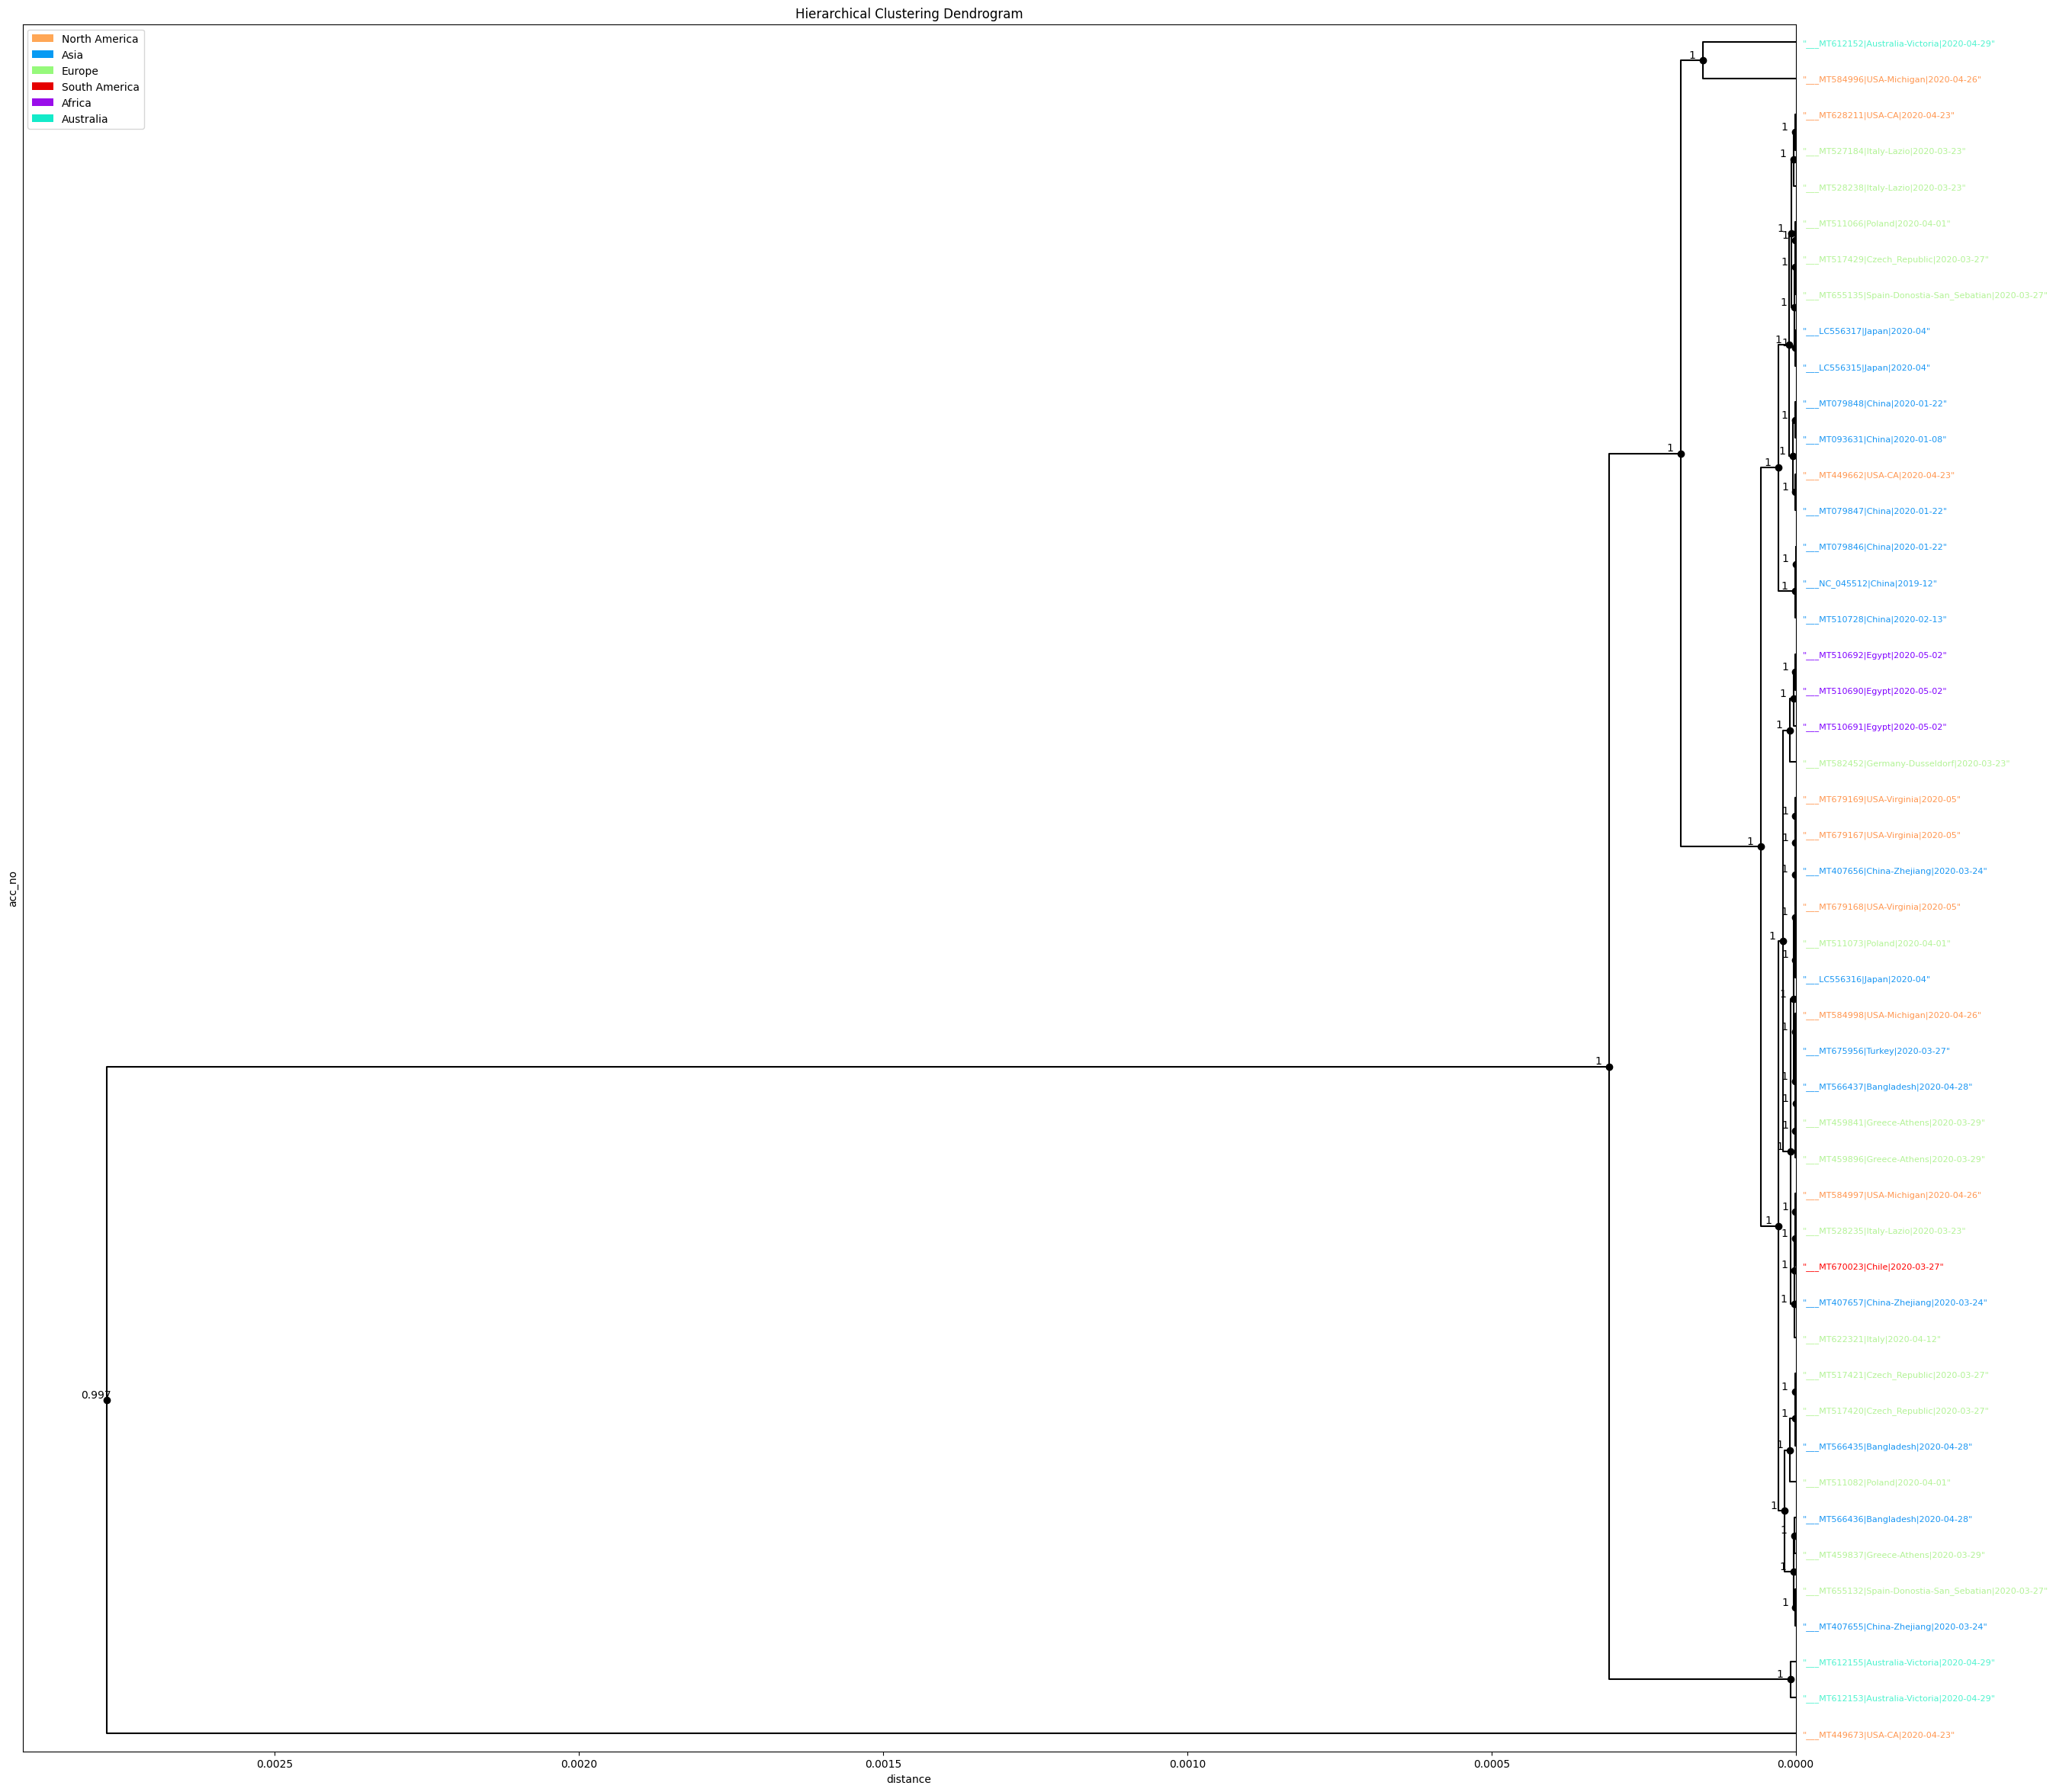

In [390]:
treeTwo=distMatCalculate(['large_dataset_sequences.fasta'], 0)
#treeTwo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

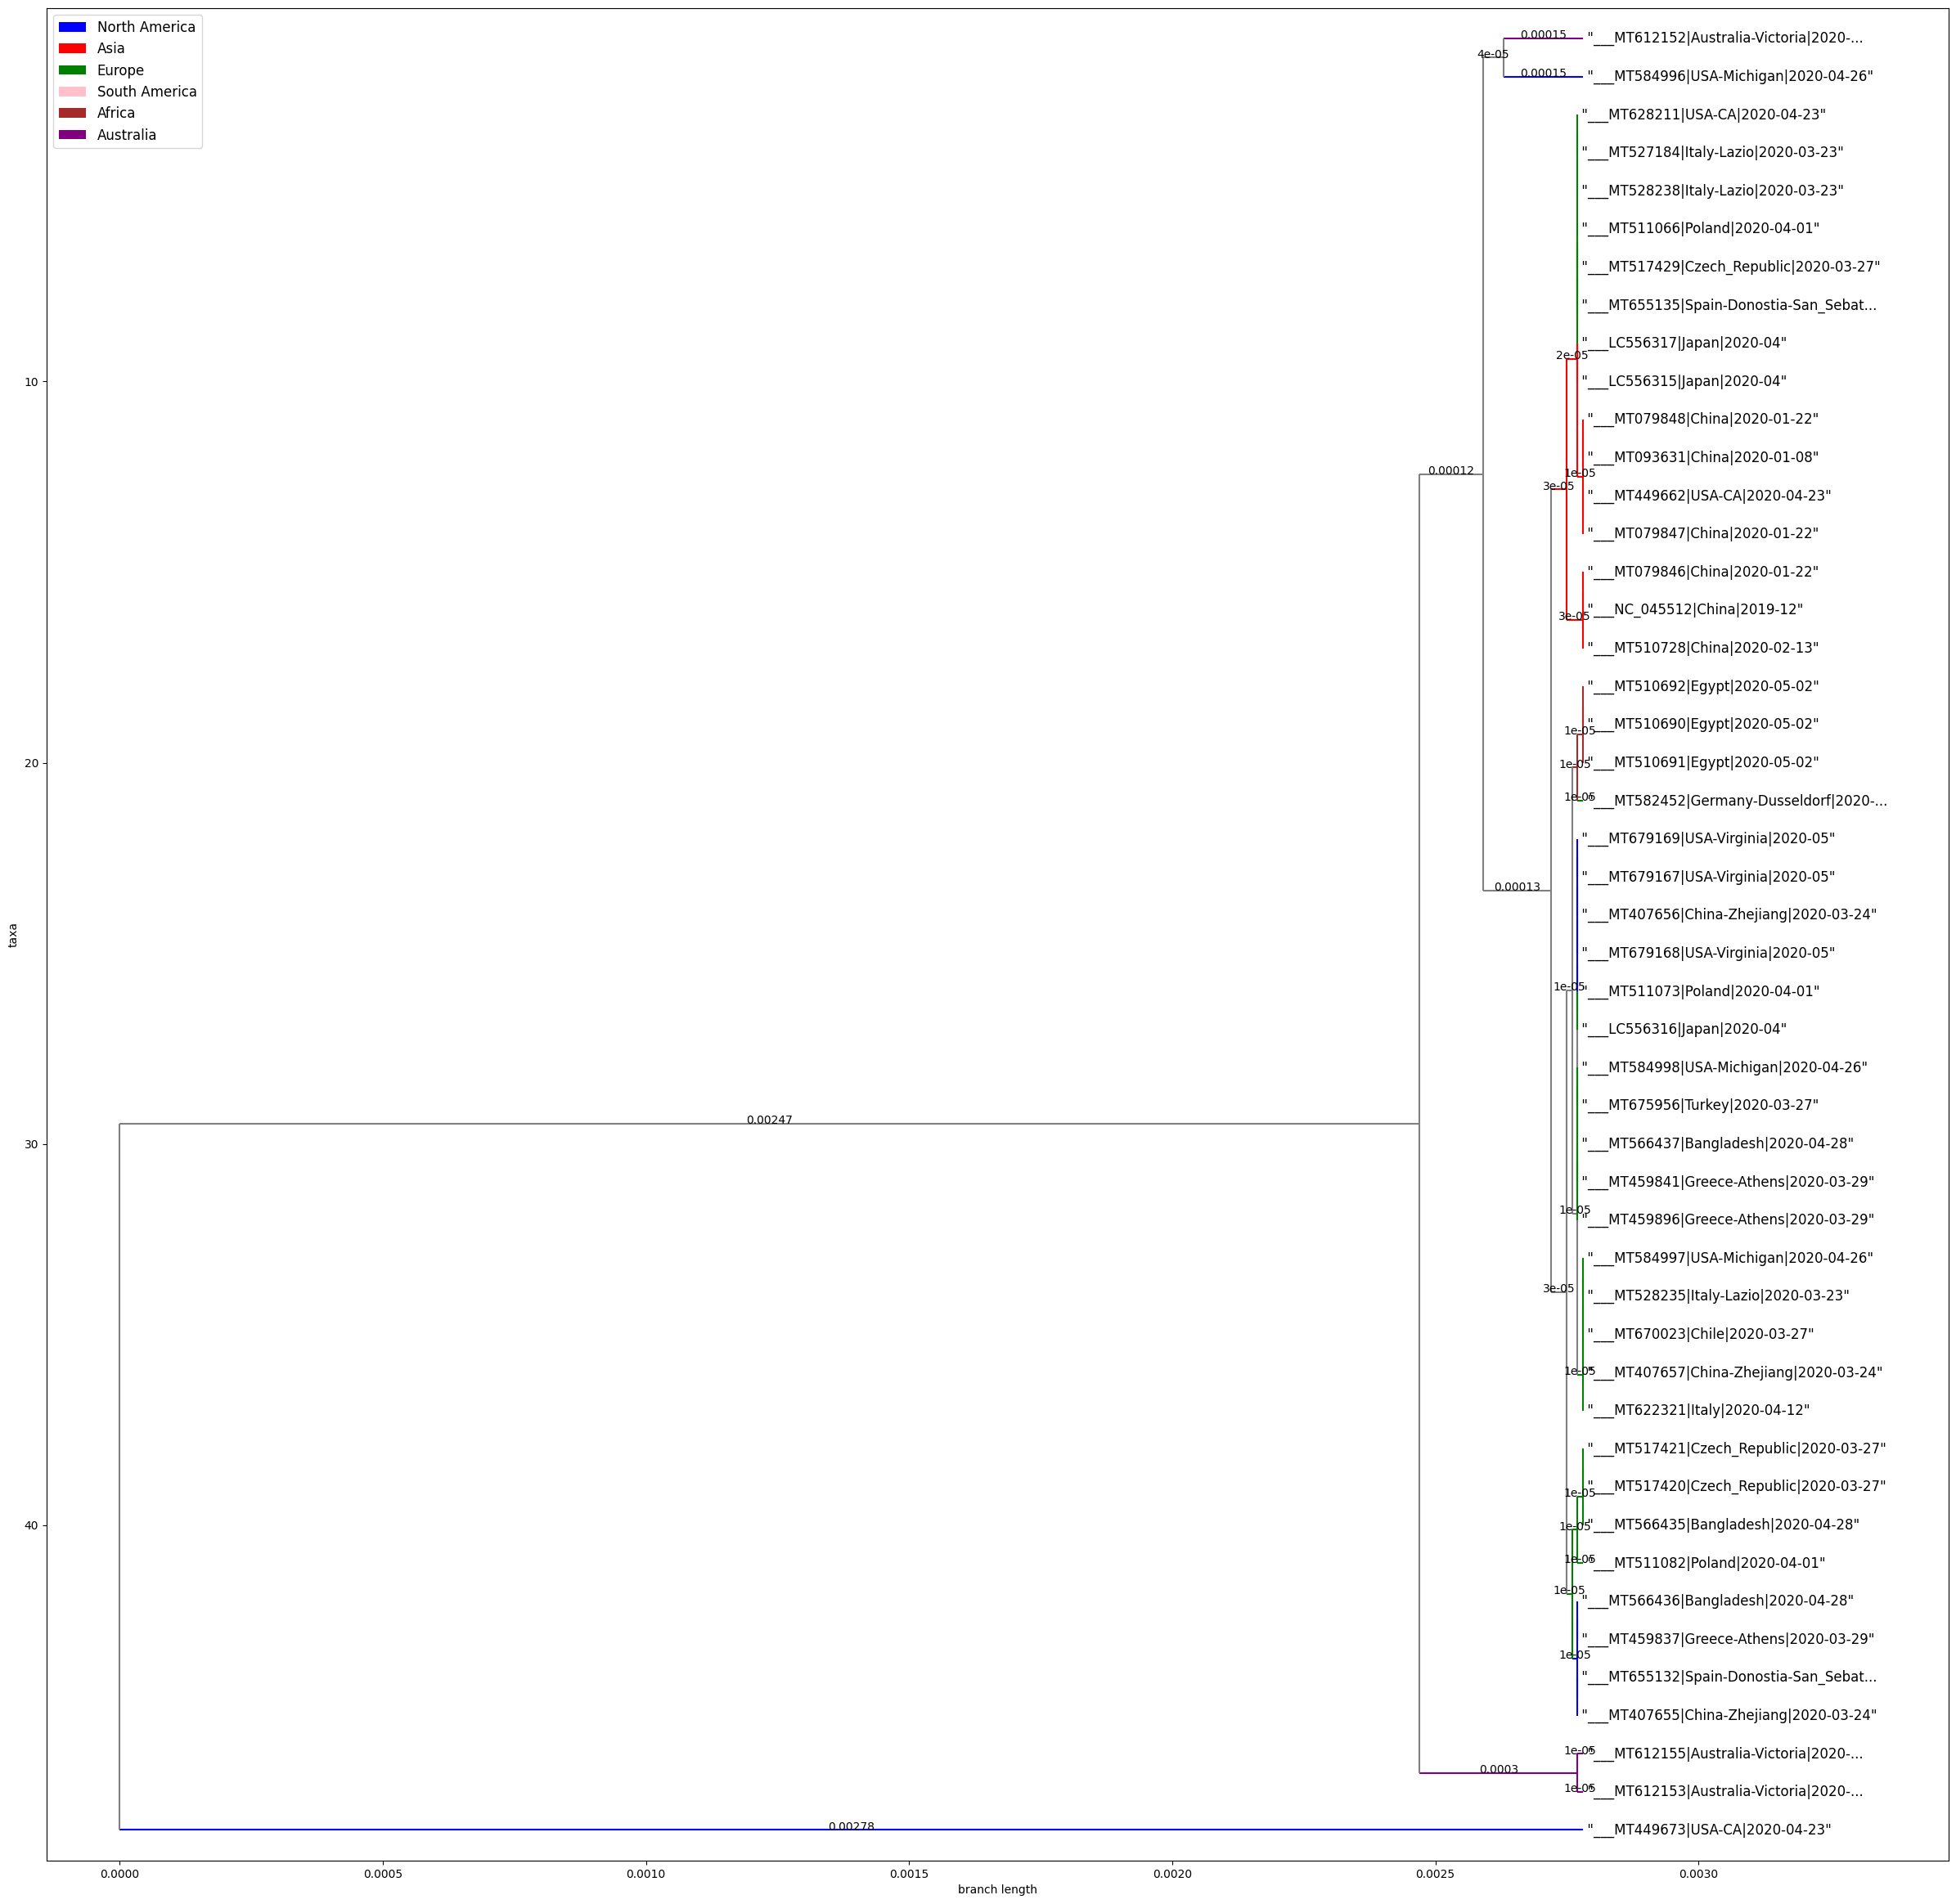

In [391]:
fig = plt.figure(figsize=(30, 30), dpi=100)
axes = fig.add_subplot(1, 1, 1)
handle = StringIO(treeTwo) # parse the newick string
tree = Phylo.read(handle, "newick")
matplotlib.rc('font', size=12)
tree.root.color = "grey"
tree.clade[1].color = "blue"
tree.clade[0,1].color = "purple"
tree.clade[0,0,0,1].color = "blue"
tree.clade[0,0,0,0].color = "purple"
tree.clade[0,0,1,1,1,1,1,1].color = "red"
tree.clade[0,0,1,1,1].color = "green"
tree.clade[0,0,1,1,0,0].color = "brown"
tree.clade[0,0,1,1,0,1,0,0].color = "blue"
tree.clade[0,0,1,1,0,1,0,1].color = "green"
tree.clade[0,0,1,1,0,1,0,1,0,0].color = "blue"
tree.clade[0,0,1,1,0,1,0,1,1,0,0].color = "red"
tree.clade[0,0,1,1,0,1,0,0,0,0,1].color = "red"
tree.clade[0,0,1,1,0,1,0,0,1].color = "green"
tree.clade[0,0,1,1,0,1,0,0,1,1].color = "red"
tree.clade[0,0,1,1,0,0,1].color = "green"
tree.clade[0,0,1,1,1,1,0,1].color = "green"
tree.clade[0,0,1,1,1,1,0,0].color = "red"
tree.clade[0,0,1,1,1,0,1].color = "green"
tree.clade[0,0,1,1,1,0,0,1].color = "red"
tree.clade[0,0,1,1,1,0,0,0].color = "green"
tree.clade[0,0,1,0,0,0,0,0,0].color="blue"
tree.clade[0,0,1,0,0,0,0,0,1].color="green"
tree.clade[0,0,1,0,0,0,0,1].color="green"
tree.clade[0,0,1,0,0,0].color="green"
tree.clade[0,0,1,0,0,0,1,1].color="red"
tree.clade[0,0,1,0].color="red"
tree.clade[0,0,1,0,0,1,1,0].color="blue"
tree.clade[0,0,1,0,0,1,1,1].color="red"
tree.clade[0,0,1,1,1,1].color="blue"
tree.clade[0,0,1,1,0,1,1].color="green"
tree.clade[0,0,1,1,0,1,1,0,0,0,0].color="blue"
tree.clade[0,0,1,1,0,1,1,0,0,1].color="pink"
tree.clade[0,0,1,1,0,1,1,0,1].color="red"
Phylo.draw(tree, axes=axes, branch_labels=lambda c: c.branch_length, do_show=False)
legend_elements = (Patch(facecolor='blue', label='North America'), Patch(facecolor='red', label='Asia'), Patch(facecolor='green', label='Europe'), Patch(facecolor='pink', label='South America'), Patch(facecolor='brown', label='Africa'), Patch(facecolor='purple', label='Australia'))
axes.legend(handles=legend_elements, loc='upper left')
import io
with io.open("/content/drive/My Drive/DSinLS20/week11/code/output/treeTwo.nwk", "w", encoding='utf-8') as output: ## creates new file but empty
    output.write(str(treeTwo))
fig.savefig("upgma_human_host_2ddnaviz.pdf")
files.download("upgma_human_host_2ddnaviz.pdf")
#print(tree)

In [392]:
%pip install dendropy
%pip install newick
from newick import read
import dendropy
from dendropy.calculate import treecompare
import io
from newick import load
phylogenetic_tree_human_UPGMA = '(((((((gb|MT079846.1:0.00075,(gb|MT079848.1:0.00030,gb|MT079847.1:0.00030)Inner20:0.00045)Inner35:0.00087,((gb|MT679168.1:0.00069,(dbj|LC556315.1:0.00032,((((dbj|LC556317.1:0.00015,dbj|LC556316.1:0.00015)Inner7:0.00003,(gb|MT511073.1:0.00013,gb|MT511066.1:0.00013)Inner5:0.00004)Inner9:0.00007,(ref|NC_045512.2:0.00008,gb|MT510728.1:0.00008)Inner2:0.00014)Inner14:0.00014,gb|MT511082.1:0.00029)Inner18:0.00003)Inner22:0.00037)Inner32:0.00054,((((gb|MT407656.1:0.00050,gb|MT407655.1:0.00050)Inner30:0.00033,(((gb|MT584998.1:0.00020,gb|MT584997.1:0.00020)Inner12:0.00039,(((gb|MT459896.1:0.00015,gb|MT459841.1:0.00015)Inner6:0.00018,(gb|MT655132.1:0.00020,gb|MT459837.1:0.00020)Inner11:0.00013)Inner23:0.00021,(((gb|MT679167.1:0.00021,(gb|MT527184.1:0.00012,gb|MT622321.1:0.00012)Inner3:0.00009)Inner13:0.00010,gb|MT655135.1:0.00031)Inner21:0.00006,(gb|MT566437.1:0.00025,(gb|MT566436.1:0.00017,gb|MT566435.1:0.00017)Inner8:0.00008)Inner16:0.00012)Inner25:0.00010)Inner27:0.00028)Inner31:0.00042,gb|MT528235.1:0.00074)Inner34:0.00009)Inner36:0.00025,gb|MT528238.1:0.00098)Inner37:0.00013,((((gb|MT093631.2:0.00027,(gb|MT517421.1:0.00020,gb|MT517429.1:0.00020)Inner10:0.00007)Inner17:0.00003,gb|MT517420.1:0.00030)Inner19:0.00011,((gb|MT679169.1:0.00023,gb|MT628211.1:0.00023)Inner15:0.00015,gb|MT675956.1:0.00038)Inner26:0.00003)Inner28:0.00033,gb|MT449662.1:0.00071)Inner33:0.00040)Inner39:0.00025)Inner40:0.00064)Inner41:0.00125,(((gb|MT670023.1:0.00033,gb|MT407657.1:0.00033)Inner24:0.00013,((gb|MT510692.1:0.00002,gb|MT510690.1:0.00002)Inner1:0.00011,gb|MT510691.1:0.00013)Inner4:0.00034)Inner29:0.00075,gb|MT582452.1:0.00108)Inner38:0.00115)Inner42:0.00189,(gb|MT612153.1:0.00252,gb|MT612155.1:0.00252)Inner43:0.00045)Inner44:0.00329,gb|MT449673.1:0.00582)Inner45:0.00368,gb|MT612152.1:0.00949)Inner46:0.00602,gb|MT584996.1:0.01551)Inner47:0.00000;'
phylogenetic_tree_different_hosts_UPGMA = '((NC_034972:0.28330,((MT084071:0.11424,(MG772934:0.05707,MN996528:0.05707)Inner1:0.05716)Inner2:0.14320,NC_019843:0.25744)Inner4:0.02586)Inner5:0.02242,(JQ065048:0.24406,KX389094:0.24406)Inner3:0.06165)Inner6:0.00000;'
treeOne=distMatCalculate(['different_hosts_sequences.fasta'], 1)
phylogenetic_tree_different_hosts_twoD=treeOne
treeTwo=distMatCalculate(['large_dataset_sequences.fasta'], 1)
phylogenetic_tree_human_twoD=treeTwo
s1=phylogenetic_tree_different_hosts_twoD
s2=phylogenetic_tree_different_hosts_UPGMA
tns=dendropy.TaxonNamespace()
tree1 = dendropy.Tree.get(
        data=s1,
        schema='newick',
        taxon_namespace=tns)
tree2 = dendropy.Tree.get(
        data=s2,
        schema='newick',
        taxon_namespace=tns)
## Euclidean distance
print(treecompare.euclidean_distance(tree1, tree2))
print(treecompare.weighted_robinson_foulds_distance(tree1, tree2))
print(treecompare.symmetric_difference(tree1, tree2))

s1=phylogenetic_tree_human_twoD
s2=phylogenetic_tree_human_UPGMA
tns=dendropy.TaxonNamespace()
tree1 = dendropy.Tree.get(
        data=s1,
        schema='newick',
        taxon_namespace=tns)
tree2 = dendropy.Tree.get(
        data=s2,
        schema='newick',
        taxon_namespace=tns)
## Euclidean distance
print(treecompare.euclidean_distance(tree1, tree2))
print(treecompare.weighted_robinson_foulds_distance(tree1, tree2))
print(treecompare.symmetric_difference(tree1, tree2))

1.726195244982444
3.4729
6
0.025865175429522994
0.08193
186
